<a href="https://colab.research.google.com/github/Anshulnagar00/Face-Recognition-API/blob/master/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lite face-Detection 

In [0]:
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import face_recognition

In [0]:
print("[INFO] loading face embeddings...")

try :
  data = pickle.loads(open("drive/My Drive/FaceRecog/embeddings.pickle", "rb").read())
except :
  print("No previous data")


# encode the labels
print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

# train the model used to accept the 128-d embeddings of the face and
# then produce the actual face recognition
print("[INFO] training model...")
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data["embeddings"], labels)

# write the actual face recognition model to disk
f = open("drive/My Drive/FaceRecog/recognizer.pickle", "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open("drive/My Drive/FaceRecog/le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()


[INFO] loading face embeddings...
[INFO] encoding labels...
[INFO] training model...


In [0]:
DATASET = "drive/My Drive/FaceRecog/dataset"
EMBEDDINGS = "drive/My Drive/FaceRecog/embeddings.pickle"
DETECTOR = "drive/My Drive/FaceRecog/face_detection_model"
CONFIDENCE = 0.5
EMBEDDING_MODEL = "drive/My Drive/FaceRecog/openface_nn4.small2.v1.t7"

# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.join(DETECTOR, "deploy.prototxt")
modelPath = os.path.join(DETECTOR,"res10_300x300_ssd_iter_140000.caffemodel")
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(EMBEDDING_MODEL)

# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(DATASET))

# initialize our lists of extracted facial embeddings and
# corresponding people names
knownEmbeddings = []
knownNames = []

# initialize the total number of faces processed
total = 0

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]

	# load the image, resize it to have a width of 600 pixels (while
	# maintaining the aspect ratio), and then grab the image
	# dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# construct a blob from the image
	imageBlob = cv2.dnn.blobFromImage(
		cv2.resize(image, (300, 300)), 1.0, (300, 300),
		(104.0, 177.0, 123.0), swapRB=False, crop=False)

	# apply OpenCV's deep learning-based face detector to localize
	# faces in the input image
	detector.setInput(imageBlob)
	detections = detector.forward()

	# ensure at least one face was found
	if len(detections) > 0:
		# we're making the assumption that each image has only ONE
		# face, so find the bounding box with the largest probability
		i = np.argmax(detections[0, 0, :, 2])
		confidence = detections[0, 0, i, 2]

		# ensure that the detection with the largest probability also
		# means our minimum probability test (thus helping filter out
		# weak detections)
		if confidence > CONFIDENCE:
			# compute the (x, y)-coordinates of the bounding box for
			# the face
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# extract the face ROI and grab the ROI dimensions
			face = image[startY:endY, startX:endX]
			(fH, fW) = face.shape[:2]

			# ensure the face width and height are sufficiently large
			if fW < 20 or fH < 20:
				continue

			# construct a blob for the face ROI, then pass the blob
			# through our face embedding model to obtain the 128-d
			# quantification of the face
			faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,
				(96, 96), (0, 0, 0), swapRB=True, crop=False)
			embedder.setInput(faceBlob)
			vec = embedder.forward()

			# add the name of the person + corresponding face
			# embedding to their respective lists
			knownNames.append(name)
			knownEmbeddings.append(vec.flatten())
			total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open(EMBEDDINGS, "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] loading face detector...
[INFO] loading face recognizer...
[INFO] quantifying faces...
[INFO] processing image 1/18
[INFO] processing image 2/18
[INFO] processing image 3/18
[INFO] processing image 4/18
[INFO] processing image 5/18
[INFO] processing image 6/18
[INFO] processing image 7/18
[INFO] processing image 8/18
[INFO] processing image 9/18
[INFO] processing image 10/18
[INFO] processing image 11/18
[INFO] processing image 12/18
[INFO] processing image 13/18
[INFO] processing image 14/18
[INFO] processing image 15/18
[INFO] processing image 16/18
[INFO] processing image 17/18
[INFO] processing image 18/18
[INFO] serializing 18 encodings...


[INFO] loading face detector...
[INFO] loading face recognizer...


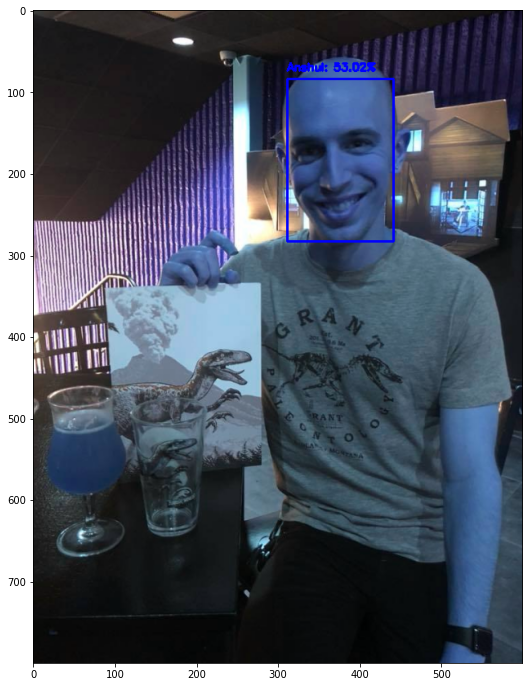

In [0]:
IMAGE = "drive/My Drive/FaceRecog/images/adrian.jpg"
LE = "drive/My Drive/FaceRecog/le.pickle"
RECOGNIZER = "drive/My Drive/FaceRecog/recognizer.pickle"



print("[INFO] loading face detector...")
protoPath = os.path.join(DETECTOR, "deploy.prototxt")
modelPath = os.path.join(DETECTOR,"res10_300x300_ssd_iter_140000.caffemodel")
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch(EMBEDDING_MODEL)

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(RECOGNIZER, "rb").read())
le = pickle.loads(open(LE, "rb").read())

# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread(IMAGE)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
	cv2.resize(image, (300, 300)), 1.0, (300, 300),
	(104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > CONFIDENCE:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob
		# through our face embedding model to obtain the 128-d
		# quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]

		# draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(image)


# using face_recognition library

In [0]:
!pip install dlib face_recognition mtcnn gevent

     |████████████████████████████████| 100.2MB 108kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=bc96a388867e50add119623a9c4beb89ac7a2c82ecb2b7edda2960888a7ec992
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
from imutils import paths
import numpy as np
import imutils
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import face_recognition
from numpy import asarray
from mtcnn.mtcnn import MTCNN

In [0]:
def add_face(name,image):
  '''
  INPUTS : name , image (in rgb channel array)
  Action : Fetch Data to encodings.pickle file
  OUTPUT : None
  '''

  # Face Detection using Mtcnn
  detector = MTCNN()
  if len(detector.detect_faces(image)) == 0 :
    print("[ERROR] No Faces Detected !")
    return 0

  # create the detector, using default weights
  # load the known faces and embeddings
  ENCODINGS = "drive/My Drive/FaceRecog/encodings.pickle"
  print("[INFO] loading encodings...")
  try :
    data = pickle.loads(open(ENCODINGS, "rb").read())
  except :
    data = {"encodings":[],"names":[]}
  rgb = image.copy()
	# detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input image
  boxes = face_recognition.face_locations(rgb,model="cnn")
  # compute the facial embedding for the face
  encodings = face_recognition.face_encodings(rgb, boxes)
  # loop over the encodings
  knownEncodings = []
  knownNames = []
  for encoding in encodings:
    # add each encoding + name to our set of known names and encodings
    knownEncodings.append(encoding)
    knownNames.append(name)
  # dump the facial encodings + names to disk
  print("[INFO] serializing encodings...")
  new = {"encodings": knownEncodings, "names": knownNames}
  for i in range(len(new['names'])):
    data['encodings'].append(new['encodings'][i])
    data['names'].append(new['names'][i])
  f = open(ENCODINGS, "wb")
  f.write(pickle.dumps(data))
  f.close()
  print("[INFO] face of {} added Sucessfully".format(name))
  return 1




def delete(lst,indexes):
  '''
  returns deleted list  
  '''
  ls = lst.copy()
  indexes.sort()
  for i,v in enumerate(indexes):
    ls.pop(v-i)
  return ls


def remove_face(name):
  ENCODINGS = "drive/My Drive/FaceRecog/encodings.pickle"
  print("[INFO] loading encodings...")
  try :
    data = pickle.loads(open(ENCODINGS, "rb").read())
  except :
    print("[ERROR] No Data !")
    return 2
  idx = [i for i in range(len(data['names'])) if data['names'][i] == name]
  if len(idx)==0:
    print("[ERROR] No face detected having name {}".format(name))
    return 0
  print("[INFO] Removing {} ...".format(name))
  for i in range(len(data['names'])):
      enc = delete(data['encodings'],indexes=idx)
      nam = delete(data['names'],indexes=idx)
  f_data = {"encodings":enc,"names":nam}
  f = open(ENCODINGS, "wb")
  f.write(pickle.dumps(f_data))
  f.close()
  print("[INFO] Done")
  return 1


def scan_face(img):

  '''
  Input : takes cv2 image in RGB color channel
  Returns : Array of Results in the Following format -
  [((top, right, bottom, left), name),((top, right, bottom, left), name), ...... ,((top, right, bottom, left), name)]
  '''
  rgb = img.copy()
  # Face Detection using Mtcnn
  detector = MTCNN()
  if len(detector.detect_faces(img)) == 0 :
    print("[ERROR] No Faces Detected !")
    return []
  # load the known faces and embeddings
  print("[INFO] loading encodings...")
  data = pickle.loads(open(ENCODINGS, "rb").read())
  # detect the (x, y)-coordinates of the bounding boxes corresponding
  # to each face in the input image, then compute the facial embeddings
  # for each face
  print("[INFO] recognizing faces...")
  boxes = face_recognition.face_locations(rgb,model="cnn")
  encodings = face_recognition.face_encodings(rgb, boxes)
  # initialize the list of names for each face detected
  names = []
  # loop over the facial embeddings
  for encoding in encodings:
    # attempt to match each face in the input image to our known
    # encodings
    matches = face_recognition.compare_faces(data["encodings"],encoding)
    name = "Unknown"
    # check to see if we have found a match
    if True in matches:
      # find the indexes of all matched faces then initialize a
      # dictionary to count the total number of times each face
      # was matched
      matchedIdxs = [i for (i, b) in enumerate(matches) if b]
      counts = {}
    # loop over the matched indexes and maintain a count for
    # each recognized face face
    for i in matchedIdxs:
      name = data["names"][i]
      counts[name] = counts.get(name, 0) + 1
    # determine the recognized face with the largest number of
    # votes (note: in the event of an unlikely tie Python will
    # select first entry in the dictionary)
    name = max(counts, key=counts.get)
    # update the list of names
    names.append(name)
  # loop over the recognized faces
  result=[]
  for (b,n) in zip(boxes, names):
    result.append((b,n))
  print("[INFO] Done !")
  return result

def preview_processed_face(img,result):
  # loop over the recognized faces
  for ((top, right, bottom, left), name) in result:
	  # draw the predicted face name on the image
	  cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
	  y = top - 15 if top - 15 > 15 else top + 15
	  cv2.putText(img, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		  0.75, (0, 255, 0), 2)

  # show the output image
  fig,ax = plt.subplots(figsize=(12,12));
  ax.imshow(img);


In [89]:
ENCODINGS = "drive/My Drive/FaceRecog/encodings.pickle"
print("[INFO] loading encodings...")
data = pickle.loads(open(ENCODINGS, "rb").read())

[INFO] loading encodings...


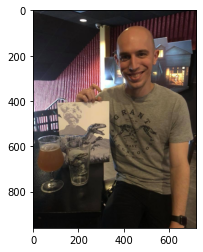

In [0]:
IMAGE = "drive/My Drive/FaceRecog/images/adrian.jpg"
img = cv2.imread(IMAGE)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

[INFO] loading encodings...
[INFO] recognizing faces...
[INFO] Done !


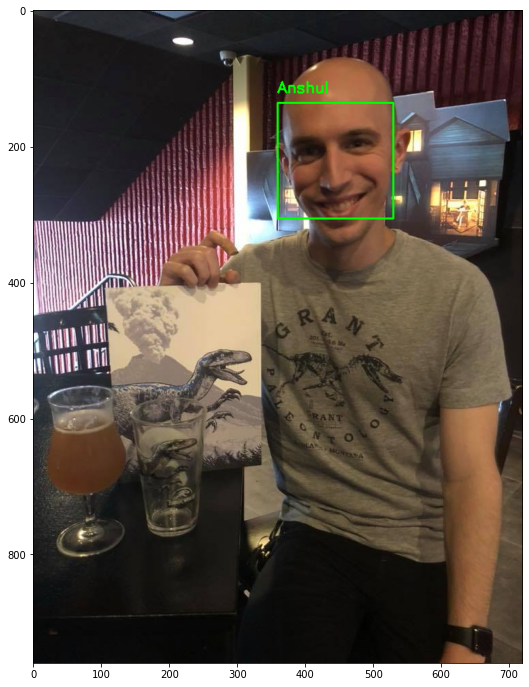

In [0]:

result = scan_face(img)
preview_processed_face(img,result)

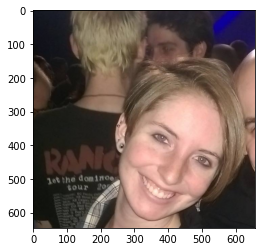

In [0]:
img_1 = cv2.imread('drive/My Drive/FaceRecog/dataset/Vandana/00000.png')
img_1 = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
plt.imshow(img_1)

In [0]:
add_face(name="Vandana" , image=img_1)

[INFO] loading encodings...
[INFO] serializing encodings...
[INFO] face of Vandana added Sucessfully


1

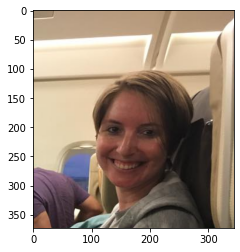

In [0]:
img_2=cv2.imread('drive/My Drive/FaceRecog/dataset/Vandana/00004.png')
img_2 = cv2.cvtColor(img_2,cv2.COLOR_BGR2RGB)
plt.imshow(img_2)

[INFO] loading encodings...
[INFO] recognizing faces...
[INFO] Done !


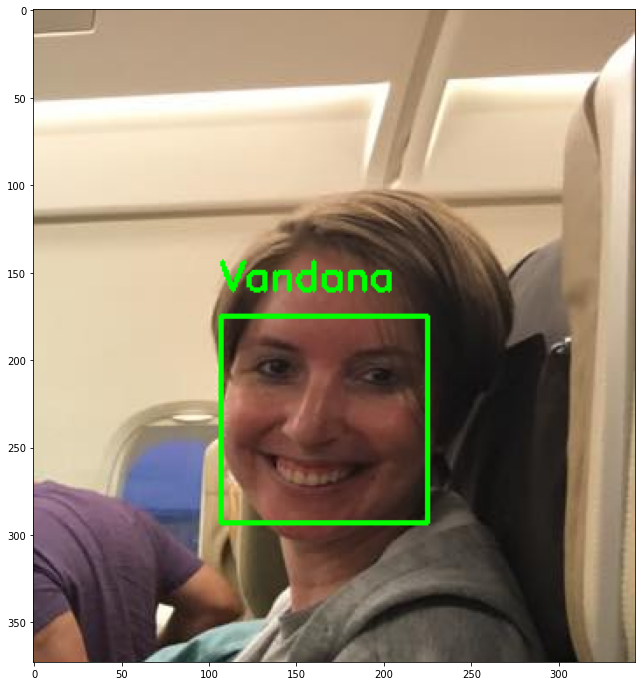

In [0]:
res = scan_face(img_2)
preview_processed_face(img_2,res)

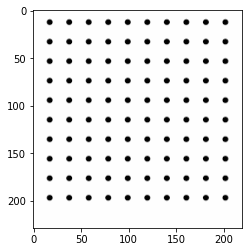

In [0]:
img_3=cv2.imread('drive/My Drive/dots.png')
img_3 = cv2.cvtColor(img_3,cv2.COLOR_BGR2RGB)
plt.imshow(img_3)

In [0]:
add_face(name="Lodu dots" , image=img_3)

[ERROR] No Faces Detected !


0

In [0]:
res = scan_face(img_3)

[ERROR] No Faces Detected !


In [0]:
res

[]

# Development Cells

In [0]:
import face_recognition

DATASET = "drive/My Drive/FaceRecog/dataset"
ENCODINGS = "drive/My Drive/FaceRecog/encodings.pickle"


# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(DATASET))

# initialize the list of known encodings and known names
knownEncodings = []
knownNames = []

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]

	# load the input image and convert it from RGB (OpenCV ordering)
	# to dlib ordering (RGB)
	image = cv2.imread(imagePath)
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	# detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input image
	boxes = face_recognition.face_locations(rgb,
		model="cnn")

	# compute the facial embedding for the face
	encodings = face_recognition.face_encodings(rgb, boxes)

	# loop over the encodings
	for encoding in encodings:
		# add each encoding + name to our set of known names and
		# encodings
		knownEncodings.append(encoding)
		knownNames.append(name)

# dump the facial encodings + names to disk
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open(ENCODINGS, "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] quantifying faces...
[INFO] processing image 1/18
[INFO] processing image 2/18
[INFO] processing image 3/18
[INFO] processing image 4/18


KeyboardInterrupt: ignored

[INFO] loading encodings...
[INFO] recognizing faces...


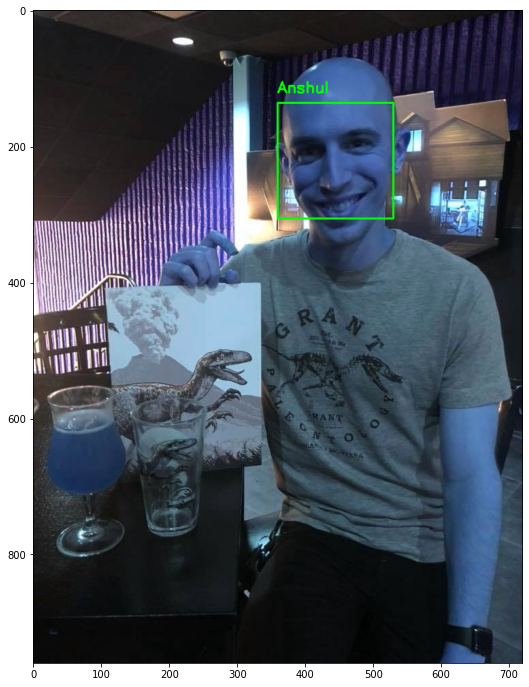

In [0]:


# load the known faces and embeddings
print("[INFO] loading encodings...")
data = pickle.loads(open(ENCODINGS, "rb").read())

# load the input image and convert it from BGR to RGB
image = cv2.imread(IMAGE)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# detect the (x, y)-coordinates of the bounding boxes corresponding
# to each face in the input image, then compute the facial embeddings
# for each face
print("[INFO] recognizing faces...")
boxes = face_recognition.face_locations(rgb,
	model="cnn")
encodings = face_recognition.face_encodings(rgb, boxes)

# initialize the list of names for each face detected
names = []

# loop over the facial embeddings
for encoding in encodings:
	# attempt to match each face in the input image to our known
	# encodings
	matches = face_recognition.compare_faces(data["encodings"],
		encoding)
	name = "Unknown"
	# check to see if we have found a match
	if True in matches:
		# find the indexes of all matched faces then initialize a
		# dictionary to count the total number of times each face
		# was matched
		matchedIdxs = [i for (i, b) in enumerate(matches) if b]
		counts = {}

		# loop over the matched indexes and maintain a count for
		# each recognized face face
		for i in matchedIdxs:
			name = data["names"][i]
			counts[name] = counts.get(name, 0) + 1

		# determine the recognized face with the largest number of
		# votes (note: in the event of an unlikely tie Python will
		# select first entry in the dictionary)
		name = max(counts, key=counts.get)

	
	# update the list of names
	names.append(name)

# loop over the recognized faces
for ((top, right, bottom, left), name) in zip(boxes, names):
	# draw the predicted face name on the image
	cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
	y = top - 15 if top - 15 > 15 else top + 15
	cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.75, (0, 255, 0), 2)

# show the output image
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(image)

In [0]:
!pip install gevent
!pip install mtcnn

     |████████████████████████████████| 5.2MB 34.0MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 2.3MB 76kB/s 


# Flask Server Setup

In [8]:
!pip install gevent
!pip install mtcnn

     |████████████████████████████████| 5.2MB 2.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 2.3MB 2.8MB/s 


In [9]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import glob
import re
import numpy as np

# Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import numpy as np
import pandas as pd
# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename

# ngrok
import atexit
import json
import platform
import shutil
import subprocess
import tempfile
import time
import zipfile
from pathlib import Path
from threading import Timer
import requests
import urllib

#later 
import cv2
from gevent.pywsgi import WSGIServer

# image 2 datauri

from PIL import Image
import io
import base64

# mtcnn classifier
from numpy import asarray
from mtcnn.mtcnn import MTCNN

import time

Using TensorFlow backend.


In [0]:
def get_command():
    system = platform.system()
    if system == "Darwin":
        command = "ngrok"
    elif system == "Windows":
        command = "ngrok.exe"
    elif system == "Linux":
        command = "ngrok"
    else:
        raise Exception("{system} is not supported".format(system=system))
    return command


def run_ngrok(port):
    command = get_command()
    ngrok_path = str(Path(tempfile.gettempdir(), "ngrok"))
    download_ngrok(ngrok_path)
    executable = str(Path(ngrok_path, command))
    os.chmod(executable, 0o777)
    ngrok = subprocess.Popen([executable, 'http', str(port)])
    atexit.register(ngrok.terminate)
    localhost_url = "http://localhost:4040/api/tunnels"  # Url with tunnel details
    time.sleep(1)
    tunnel_url = requests.get(localhost_url).text  # Get the tunnel information
    j = json.loads(tunnel_url)

    tunnel_url = j['tunnels'][0]['public_url']  # Do the parsing of the get
    tunnel_url = tunnel_url.replace("https", "http")
    return tunnel_url


def download_ngrok(ngrok_path):
    if Path(ngrok_path).exists():
        return
    system = platform.system()
    if system == "Darwin":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-darwin-amd64.zip"
    elif system == "Windows":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-windows-amd64.zip"
    elif system == "Linux":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip"
    else:
        raise Exception(f"{system} is not supported")
    download_path = download_file(url)
    with zipfile.ZipFile(download_path, "r") as zip_ref:
        zip_ref.extractall(ngrok_path)


def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    download_path = str(Path(tempfile.gettempdir(), local_filename))
    with open(download_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    return download_path


def start_ngrok(port):
    cv=True
    ngrok_address = run_ngrok(port)
    data=ngrok_address
    if cv:
      f=open("Logs.txt",'w')
      f.write(data)
      f.close()
      cv=False
    print(f" * Running on {ngrok_address}")
    print(f" * Traffic stats available on http://127.0.0.1:4040")
    



def run_with_ngrok(app):
    """
    The provided Flask app will be securely exposed to the public internet via ngrok when run,
    and the its ngrok address will be printed to stdout
    :param app: a Flask application object
    :return: None
    """
    old_run = app.run

    def new_run(*args, **kwargs):
        port = kwargs.get('port', 5000)
        thread = Timer(1, start_ngrok, args=(port,))
        thread.setDaemon(True)
        thread.start()
        old_run(*args, **kwargs)
    app.run = new_run

In [0]:
UPLOAD_FOLDER = 'uploads'
ALLOWED_EXTENSIONS = {'txt', 'pdf', 'png', 'jpg', 'jpeg', 'gif'}

# Define a flask app
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
run_with_ngrok(app)


def image_2_dataURI(image):
  img = Image.fromarray(image,'RGB')
  rawBytes = io.BytesIO()
  img.save(rawBytes, "PNG")
  rawBytes.seek(0)  # return to the start of the file
  data = "data:image/*;base64,"+base64.b64encode(rawBytes.read()).decode("UTF-8")
  return data

def dataURI_2_image(URIstr):
  response = urllib.request.urlopen(URIstr)
  img = response.file.read()
  nparr = np.fromstring(img, np.uint8);
  img = cv2.imdecode(nparr,cv2.IMREAD_COLOR);
  return img


@app.route('/', methods=['GET'])
def index():
    return "<h1>Pred api</h1>"


@app.route('/add', methods=['GET', 'POST'])
def add_face_2_server():
    if request.method == 'POST':
        # Get the file from post request
        image = request.form['image']
        name = request.form['name']
        img = dataURI_2_image(image)
        C01 = add_face(name,img)
        if C01 == 1 :
          return '{"status":1}'
        else:
          return '{"status":0}'
    return None

@app.route('/remove', methods=['GET', 'POST'])
def remove_face_on_server():
    if request.method == 'POST':
        # Get the file from post request
        name = request.form['name']
        C01 = remove_face(name)
        if C01 == 1 :
          return '{"status":1}'
        else:
          return '{"status":0}'
    return None


@app.route('/scan', methods=['GET', 'POST'])
def scan_face_on_server():
    if request.method == 'POST':
        image = request.form['image']
        img = dataURI_2_image(image)
        results = scan_face(img)
        res = []
        for i in range(len(results)):
          res.append(results[0][1])
        if len(res) == 0:
          return '{"status":0}'
        data = {"status":0,"result":res}
        return json.dumps(data)
      


In [169]:
if __name__ == '__main__':
    app.run(threaded=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


# Send request

In [0]:
URL = 'http://d734df76.ngrok.io'

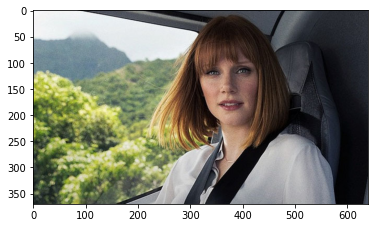

In [163]:
img = cv2.imread("drive/My Drive/FaceRecog/dataset/unknown/claire_dearing.jpg")
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [165]:
r = requests.post(URL+'/add_user',{"username":"Anna","password":"12345"})
r.text

'{"status":0}'

In [166]:
r = requests.post(URL+'/add',{"name":"Anna","image":image_2_dataURI(img),"username":"Anna","password":"12345"})
r.text

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

In [0]:
r = requests.post(URL+'/scan',{"image":image_2_dataURI(img)})
r.text

In [0]:
r = requests.post(URL+'/remove',{"name":"Anna"})
r.text

# FaceRecognition API

In [0]:
from __future__ import division, print_function
import sys
import os
import glob
import re
import numpy as np
from flask import Flask, redirect, url_for, request, render_template
import json
import requests
import urllib
import cv2
from gevent.pywsgi import WSGIServer
from PIL import Image
import io
import base64
import time
from imutils import paths
import imutils
import pickle
import face_recognition
from numpy import asarray
from mtcnn.mtcnn import MTCNN

In [0]:
# Necessary Imports

from __future__ import division, print_function
import sys
import os
import glob
import re
import numpy as np
from flask import Flask, redirect, url_for, request, render_template
import json
import requests
import urllib
import cv2
from gevent.pywsgi import WSGIServer
from PIL import Image
import io
import base64
import time
from imutils import paths
import imutils
import pickle
import face_recognition
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# Define a flask app

app = Flask(__name__)

# Define Global Variables
ENCODINGS = "drive/My Drive/FaceRecog/encodings.pickle"

def add_face(name,image):
  '''
  INPUTS : name , image (in rgb channel array)
  Action : Fetch Data to encodings.pickle file
  OUTPUT : None
  '''

  # Face Detection using Mtcnn
  detector = MTCNN()
  if len(detector.detect_faces(image)) == 0 :
    print("[ERROR] No Faces Detected !")
    return 0

  # create the detector, using default weights
  # load the known faces and embeddings
  print("[INFO] loading encodings...")
  try :
    data = pickle.loads(open(ENCODINGS, "rb").read())
  except :
    data = {"encodings":[],"names":[]}
  rgb = image.copy()
	# detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input image
  boxes = face_recognition.face_locations(rgb,model="cnn")
  # compute the facial embedding for the face
  encodings = face_recognition.face_encodings(rgb, boxes)
  # loop over the encodings
  knownEncodings = []
  knownNames = []
  for encoding in encodings:
    # add each encoding + name to our set of known names and encodings
    knownEncodings.append(encoding)
    knownNames.append(name)
  # dump the facial encodings + names to disk
  print("[INFO] serializing encodings...")
  new = {"encodings": knownEncodings, "names": knownNames}
  for i in range(len(new['names'])):
    data['encodings'].append(new['encodings'][i])
    data['names'].append(new['names'][i])
  f = open(ENCODINGS, "wb")
  f.write(pickle.dumps(data))
  f.close()
  print("[INFO] face of {} added Sucessfully".format(name))
  return 1




def delete(lst,indexes):
  '''
  returns deleted list  
  '''
  ls = lst.copy()
  indexes.sort()
  for i,v in enumerate(indexes):
    ls.pop(v-i)
  return ls


def remove_face(name):

  print("[INFO] loading encodings...")
  try :
    data = pickle.loads(open(ENCODINGS, "rb").read())
  except :
    print("[ERROR] No Data !")
    return 2
  idx = [i for i in range(len(data['names'])) if data['names'][i] == name]
  if len(idx)==0:
    print("[ERROR] No face detected having name {}".format(name))
    return 0
  print("[INFO] Removing {} ...".format(name))
  for i in range(len(data['names'])):
      enc = delete(data['encodings'],indexes=idx)
      nam = delete(data['names'],indexes=idx)
  f_data = {"encodings":enc,"names":nam}
  f = open(ENCODINGS, "wb")
  f.write(pickle.dumps(f_data))
  f.close()
  print("[INFO] Done")
  return 1


def scan_face(img):

  '''
  Input : takes cv2 image in RGB color channel
  Returns : Array of Results in the Following format -
  [((top, right, bottom, left), name),((top, right, bottom, left), name), ...... ,((top, right, bottom, left), name)]
  '''
  rgb = img.copy()
  # Face Detection using Mtcnn
  detector = MTCNN()
  if len(detector.detect_faces(img)) == 0 :
    print("[ERROR] No Faces Detected !")
    return []
  # load the known faces and embeddings
  print("[INFO] loading encodings...")
  data = pickle.loads(open(ENCODINGS, "rb").read())
  # detect the (x, y)-coordinates of the bounding boxes corresponding
  # to each face in the input image, then compute the facial embeddings
  # for each face
  print("[INFO] recognizing faces...")
  boxes = face_recognition.face_locations(rgb,model="cnn")
  encodings = face_recognition.face_encodings(rgb, boxes)
  # initialize the list of names for each face detected
  names = []
  # loop over the facial embeddings
  for encoding in encodings:
    # attempt to match each face in the input image to our known
    # encodings
    matches = face_recognition.compare_faces(data["encodings"],encoding)
    name = "Unknown"
    # check to see if we have found a match
    if True in matches:
      # find the indexes of all matched faces then initialize a
      # dictionary to count the total number of times each face
      # was matched
      matchedIdxs = [i for (i, b) in enumerate(matches) if b]
      counts = {}
    # loop over the matched indexes and maintain a count for
    # each recognized face face
    for i in matchedIdxs:
      name = data["names"][i]
      counts[name] = counts.get(name, 0) + 1
    # determine the recognized face with the largest number of
    # votes (note: in the event of an unlikely tie Python will
    # select first entry in the dictionary)
    name = max(counts, key=counts.get)
    # update the list of names
    names.append(name)
  # loop over the recognized faces
  result=[]
  for (b,n) in zip(boxes, names):
    result.append((b,n))
  print("[INFO] Done !")
  return result

def preview_processed_face(img,result):
  # loop over the recognized faces
  for ((top, right, bottom, left), name) in result:
	  # draw the predicted face name on the image
	  cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
	  y = top - 15 if top - 15 > 15 else top + 15
	  cv2.putText(img, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		  0.75, (0, 255, 0), 2)


def image_2_dataURI(image):
  img = Image.fromarray(image,'RGB')
  rawBytes = io.BytesIO()
  img.save(rawBytes, "PNG")
  rawBytes.seek(0)  # return to the start of the file
  data = "data:image/*;base64,"+base64.b64encode(rawBytes.read()).decode("UTF-8")
  return data

def dataURI_2_image(URIstr):
  response = urllib.request.urlopen(URIstr)
  img = response.file.read()
  nparr = np.fromstring(img, np.uint8);
  img = cv2.imdecode(nparr,cv2.IMREAD_COLOR);
  return img


@app.route('/', methods=['GET'])
def index():
    return "<h1>Pred api</h1>"


@app.route('/add', methods=['GET', 'POST'])
def add_face_2_server():
    if request.method == 'POST':
        # Get the file from post request
        image = request.form['image']
        name = request.form['name']
        img = dataURI_2_image(image)
        C01 = add_face(name,img)
        if C01 == 1 :
          return '{"status":1}'
        else:
          return '{"status":0}'
    return None

@app.route('/remove', methods=['GET', 'POST'])
def remove_face_on_server():
    if request.method == 'POST':
        # Get the file from post request
        name = request.form['name']
        C01 = remove_face(name)
        if C01 == 1 :
          return '{"status":1}'
        else:
          return '{"status":0}'
    return None


@app.route('/scan', methods=['GET', 'POST'])
def scan_face_on_server():
    if request.method == 'POST':
        image = request.form['image']
        img = dataURI_2_image(image)
        results = scan_face(img)
        res = []
        for i in range(len(results)):
          res.append(results[0][1])
        if len(res) == 0:
          return '{"status":0}'
        data = {"status":0,"result":res}
        return json.dumps(data)
      

In [168]:
if __name__ == '__main__':
    app.run(threaded=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


# Upload and retrive Data from firebase

In [91]:
data = pickle.loads(open(ENCODINGS, "rb").read())
data

{'encodings': [array([-7.31627867e-02,  1.77161247e-02,  4.60417308e-02, -3.37142497e-03,
         -6.65159225e-02,  4.47856588e-03, -3.75772640e-02, -4.01463844e-02,
          1.28968611e-01, -3.23548466e-02,  2.62474716e-01, -6.16739169e-02,
         -2.15883955e-01, -1.68620385e-02, -1.98168233e-02,  1.23457268e-01,
         -1.65492624e-01, -7.87272602e-02, -1.10039480e-01, -9.77215469e-02,
          1.48045361e-01, -3.86654735e-02, -1.77610647e-02,  7.23031908e-02,
         -2.45270520e-01, -3.02487224e-01, -5.47734387e-02, -1.70053139e-01,
          3.54237184e-02, -6.57403395e-02,  5.17559703e-03, -1.91004563e-03,
         -9.68630165e-02,  2.99569555e-02,  3.73836011e-02,  4.34099473e-02,
         -1.96092855e-03, -8.12772885e-02,  1.96384430e-01, -3.30977701e-02,
         -1.74608439e-01,  1.37401074e-01,  5.96152619e-02,  2.13958234e-01,
          1.52841404e-01,  3.93374041e-02,  1.22639321e-01, -6.30116686e-02,
          1.49365768e-01, -2.69693464e-01,  1.07769489e-01,  1.

In [0]:
databytestr = open(ENCODINGS, "rb").read()
datab64 = base64.encodebytes(databytestr)
data = datab64.decode('utf-8')

In [111]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db


# Fetch the service account key JSON file contents
cred = credentials.Certificate('drive/My Drive/FaceRecog/face-recognition-api-329bf-firebase-adminsdk-osjjv-a075fb4a6c.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://face-recognition-api-329bf.firebaseio.com/'
})

# As an admin, the app has access to read and write all data, regradless of Security Rules
ref = db.reference('restricted_access/secret_document')

ValueError: ignored

In [0]:
user = db.reference('userdata').child("anshul").child("FaceData")
user.set(str(data))

In [0]:
datastr = user.get()

In [114]:
datastr

'gAN9cQAoWAkAAABlbmNvZGluZ3NxAV1xAihjbnVtcHkuY29yZS5tdWx0aWFycmF5Cl9yZWNvbnN0\ncnVjdApxA2NudW1weQpuZGFycmF5CnEESwCFcQVDAWJxBodxB1JxCChLAUuAhXEJY251bXB5CmR0\neXBlCnEKWAIAAABmOHELSwBLAYdxDFJxDShLA1gBAAAAPHEOTk5OSv////9K/////0sAdHEPYolC\nAAQAAAAAAODLurK/AAAAAC0kkj8AAAAgyJKnPwAAAABknmu/AAAAADAHsb8AAADgHVhyPwAAAMBT\nPaO/AAAAIBGOpL8AAAAgC4LAPwAAAIDQkKC/AAAAwGLM0D8AAABAuZOvvwAAAOAVosu/AAAAQEhE\nkb8AAACA3EqUvwAAAEDlmr8/AAAAwNwuxb8AAABAeCe0vwAAACCMK7y/AAAAgEcEub8AAACAJvPC\nPwAAAAD2y6O/AAAA4PQvkr8AAABAdoKyPwAAAEAGZc+/AAAAYPNb078AAACgQwusvwAAACBNxMW/\nAAAAwA4joj8AAADgW9SwvwAAAMABM3U/AAAA4E9LX78AAADAA8y4vwAAAEAJrZ4/AAAAgPEjoz8A\nAAAg1DmmPwAAAIBdEGC/AAAAoJbOtL8AAAAAICPJPwAAAOAw8qC/AAAAwJFZxr8AAADAW5bBPwAA\nAEDkha4/AAAAwPtiyz8AAACgTpDDPwAAAEAIJKQ/AAAAYEplvz8AAABgiCGwvwAAAOBqHsM/AAAA\nYKhC0b8AAAAAyJa7PwAAAGDxOMM/AAAAIDT6wT8AAADAm+azPwAAAOBd1MU/AAAAgKrDyr8AAAAA\nJNepvwAAAIDUPsw/AAAAgAPgwr8AAADAHvjHPwAAAABCMGc/AAAAwKCDmj8AAACApiKXPwAAAAAM\nW7+/AAAA4AIbxD8AAABA+FfBPwAAACDL08e/AAAA4Cmuu78AAAAg3P2+PwAAAMB

In [0]:
response = urllib.request.urlopen("data:image/png;base64,"+datastr)
data = response.file.read()

In [116]:
data

b'\x80\x03}q\x00(X\t\x00\x00\x00encodingsq\x01]q\x02(cnumpy.core.multiarray\n_reconstruct\nq\x03cnumpy\nndarray\nq\x04K\x00\x85q\x05C\x01bq\x06\x87q\x07Rq\x08(K\x01K\x80\x85q\tcnumpy\ndtype\nq\nX\x02\x00\x00\x00f8q\x0bK\x00K\x01\x87q\x0cRq\r(K\x03X\x01\x00\x00\x00<q\x0eNNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00tq\x0fb\x89B\x00\x04\x00\x00\x00\x00\x00\xe0\xcb\xba\xb2\xbf\x00\x00\x00\x00-$\x92?\x00\x00\x00 \xc8\x92\xa7?\x00\x00\x00\x00d\x9ek\xbf\x00\x00\x00\x000\x07\xb1\xbf\x00\x00\x00\xe0\x1dXr?\x00\x00\x00\xc0S=\xa3\xbf\x00\x00\x00 \x11\x8e\xa4\xbf\x00\x00\x00 \x0b\x82\xc0?\x00\x00\x00\x80\xd0\x90\xa0\xbf\x00\x00\x00\xc0b\xcc\xd0?\x00\x00\x00@\xb9\x93\xaf\xbf\x00\x00\x00\xe0\x15\xa2\xcb\xbf\x00\x00\x00@HD\x91\xbf\x00\x00\x00\x80\xdcJ\x94\xbf\x00\x00\x00@\xe5\x9a\xbf?\x00\x00\x00\xc0\xdc.\xc5\xbf\x00\x00\x00@x\'\xb4\xbf\x00\x00\x00 \x8c+\xbc\xbf\x00\x00\x00\x80G\x04\xb9\xbf\x00\x00\x00\x80&\xf3\xc2?\x00\x00\x00\x00\xf6\xcb\xa3\xbf\x00\x00\x00\xe0\xf4/\x92\xbf\x00\x00\x00@v\x82\xb2?\x00\

In [117]:
pickle.loads(data)

{'encodings': [array([-7.31627867e-02,  1.77161247e-02,  4.60417308e-02, -3.37142497e-03,
         -6.65159225e-02,  4.47856588e-03, -3.75772640e-02, -4.01463844e-02,
          1.28968611e-01, -3.23548466e-02,  2.62474716e-01, -6.16739169e-02,
         -2.15883955e-01, -1.68620385e-02, -1.98168233e-02,  1.23457268e-01,
         -1.65492624e-01, -7.87272602e-02, -1.10039480e-01, -9.77215469e-02,
          1.48045361e-01, -3.86654735e-02, -1.77610647e-02,  7.23031908e-02,
         -2.45270520e-01, -3.02487224e-01, -5.47734387e-02, -1.70053139e-01,
          3.54237184e-02, -6.57403395e-02,  5.17559703e-03, -1.91004563e-03,
         -9.68630165e-02,  2.99569555e-02,  3.73836011e-02,  4.34099473e-02,
         -1.96092855e-03, -8.12772885e-02,  1.96384430e-01, -3.30977701e-02,
         -1.74608439e-01,  1.37401074e-01,  5.96152619e-02,  2.13958234e-01,
          1.52841404e-01,  3.93374041e-02,  1.22639321e-01, -6.30116686e-02,
          1.49365768e-01, -2.69693464e-01,  1.07769489e-01,  1.

In [150]:
def add_new_user(name,password):
    names = list(db.reference('users').get().values())
    if names.count(name) == 0:
        users = db.reference('users')
        users.push(name)
        userdata = db.reference('userdata').child(name)
        userdata.child("password").set(password)
        print("[INFO] User "+name+" added Sucessfully")
        return 1
    else:
        print("[ERROR] Username already exist")
        return 0

add_new_user("Anshul","123456")

[ERROR] Username already exist


0

In [0]:
def verify_user(name,password):
  names = list(db.reference('users').get().values())
  if names.count(name) == 1:
    if db.reference('userdata').child("Anshul").child("password").get() == password :
      return 1
    else :
      return 0
  else :
    return 0


In [0]:
def set_data(name,password,databytestr):
  if verify_user(name,password) == 0 :
    return 0
  datab64 = base64.encodebytes(databytestr)
  data = datab64.decode('utf-8')
  db.reference('userdata').child(name).child("facedata").set(str(data))
  return 1

def get_data(name,password,databytestr):
  if verify_user(name,password) == 0 :
    return 0
  bytestr = db.reference('userdata').child(name).child("facedata").get()
  response = urllib.request.urlopen("data:image/png;base64,"+bytestr)
  data = response.file.read()
  return data

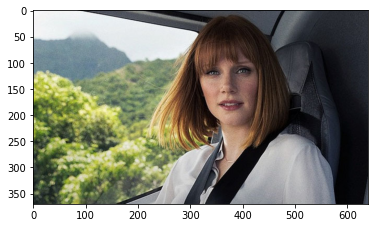

In [21]:
import cv2 
import requests
import matplotlib.pyplot as plt

URL = 'http://08abc74a.ngrok.io'

img = cv2.imread("drive/My Drive/FaceRecog/dataset/unknown/claire_dearing.jpg")
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [22]:
# Add New User
r = requests.post(URL+'/add_user',{"username":"Anshul Nagar","password":"12345"})
r.text

'{"status":0}'

In [23]:
r = requests.post(URL+'/add',{"name":"Anna","image":image_2_dataURI(img),"username":"Anshul Nagar","password":"12345"})
r.text

'{"status":1}'

In [24]:
r = requests.post(URL+'/scan',{"image":image_2_dataURI(img),"username":"Anshul Nagar","password":"12345"})
r.text

'{"status": 0, "result": ["Anna"]}'